In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import models, layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Normalize Data

In [3]:
data_path = '../dataset'

test_data = data_path + '/test'
train_data = data_path + '/train'
validation_data = data_path + '/validation'

for split_name, split_path in zip(['Train', 'Validation', 'Test'], [train_data, validation_data, test_data]):
    print(f"{split_name} set:")
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if os.path.isdir(class_dir):
            count = len([img for img in os.listdir(class_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"  {class_name}: {count} images")
    print()

Train set:
  dimes: 28 images
  nickels: 849 images
  pennies: 899 images
  quarters: 875 images

Validation set:
  dimes: 4 images
  nickels: 182 images
  pennies: 192 images
  quarters: 187 images

Test set:
  dimes: 4 images
  nickels: 183 images
  pennies: 194 images
  quarters: 188 images



In [6]:
import random
from tensorflow.keras.preprocessing.image import save_img

# Set paths
dime_train_dir = os.path.join(train_data, 'dimes')
dime_val_dir = os.path.join(validation_data, 'dimes')
dime_test_dir = os.path.join(test_data, 'dimes')

# Augmentation generators
strong_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

light_aug = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.95, 1.05],
    fill_mode='nearest'
)

def augment_images(target_count, source_dir, dest_dir, aug_gen, prefix='aug'):
    os.makedirs(dest_dir, exist_ok=True)
    existing = [f for f in os.listdir(dest_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    current = len(existing)
    
    if current >= target_count:
        print(f"{dest_dir} already has {current} images.")
        return

    print(f"Augmenting {dest_dir}: {current} -> {target_count}")
    
    source_imgs = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not source_imgs:
        print(f"Warning: No source images found in {source_dir}. Skipping augmentation.")
        return
    random.shuffle(source_imgs)
    
    img_idx = 0
    save_idx = current

    while current < target_count:
        img_path = os.path.join(source_dir, source_imgs[img_idx % len(source_imgs)])
        img = load_img(img_path, target_size=(224, 224))
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        aug_img = next(aug_gen.flow(x, batch_size=1))[0]
        save_path = os.path.join(dest_dir, f'{prefix}_{save_idx}.png')
        save_img(save_path, aug_img)

        current += 1
        save_idx += 1
        img_idx += 1

# Apply augmentations
augment_images(target_count=850, source_dir=dime_train_dir, dest_dir=dime_train_dir, aug_gen=strong_aug)
augment_images(target_count=180, source_dir=dime_train_dir, dest_dir=dime_val_dir, aug_gen=light_aug)
augment_images(target_count=180, source_dir=dime_train_dir, dest_dir=dime_test_dir, aug_gen=light_aug)


Augmenting ../dataset/train\dimes: 28 -> 850
Augmenting ../dataset/validation\dimes: 4 -> 180
Augmenting ../dataset/test\dimes: 4 -> 180


Train Model

In [22]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    brightness_range = [0.8, 1.2],
    horizontal_flip = True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale= 1./255
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)


train_generator = train_datagen.flow_from_directory(
    '../dataset/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '../dataset/validation',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
)

test_generator = test_datagen.flow_from_directory(
    '../dataset/test',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)



Found 3473 images belonging to 4 classes.
Found 741 images belonging to 4 classes.
Found 745 images belonging to 4 classes.


In [9]:
train_dir = '../dataset/train'

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{class_name}: {count} images")

quarters: 875 images
pennies: 899 images
dimes: 850 images
nickels: 849 images


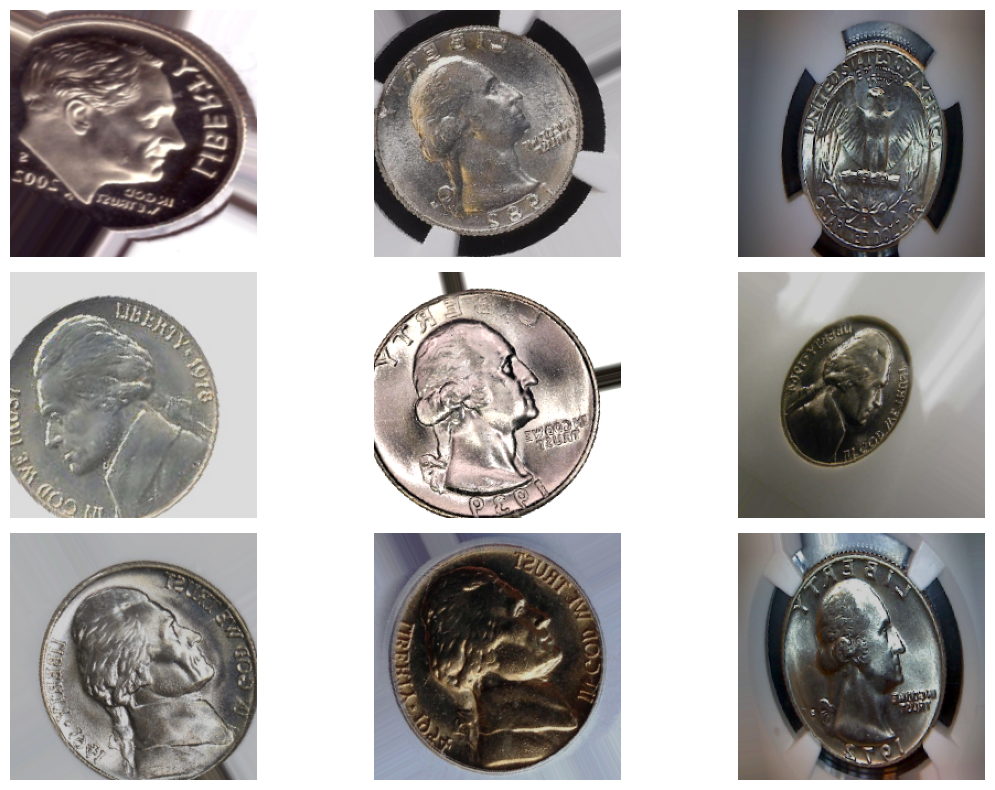

In [10]:
images, labels = next(train_generator)
plt.figure(figsize=(12, 8))
for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
model = models.Sequential([
   layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
   layers.MaxPool2D(pool_size=(2, 2)),
   layers.Conv2D(64, (3, 3), activation='relu'),
   layers.MaxPool2D(pool_size=(2, 2)),
   layers.Flatten(),
   layers.Dense(64, activation='relu'),
   layers.Dropout(0.5),
   layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='best_coin_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

callbacks = [checkpoint, earlystop]

In [25]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks= callbacks)

Epoch 1/50


2025-05-14 20:54:00.760030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


109/109 [==============================] - ETA: 0s - loss: 1.6044 - accuracy: 0.4895

2025-05-14 20:54:45.038383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.55601, saving model to best_coin_model.h5
109/109 [==============================] - 48s 434ms/step - loss: 1.6044 - accuracy: 0.4895 - val_loss: 1.0612 - val_accuracy: 0.5560
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 0.8997 - accuracy: 0.6110
Epoch 2: val_accuracy improved from 0.55601 to 0.81916, saving model to best_coin_model.h5
109/109 [==============================] - 53s 481ms/step - loss: 0.8997 - accuracy: 0.6110 - val_loss: 0.6866 - val_accuracy: 0.8192
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.7112
Epoch 3: val_accuracy improved from 0.81916 to 0.86370, saving model to best_coin_model.h5
109/109 [==============================] - 998s 9s/step - loss: 0.7412 - accuracy: 0.7112 - val_loss: 0.4696 - val_accuracy: 0.8637
Epoch 4/50
109/109 [==============================] - ETA: 0s - loss: 0.6484 - accuracy: 0.7567
Epoch 4: val_accuracy improved from 0.863

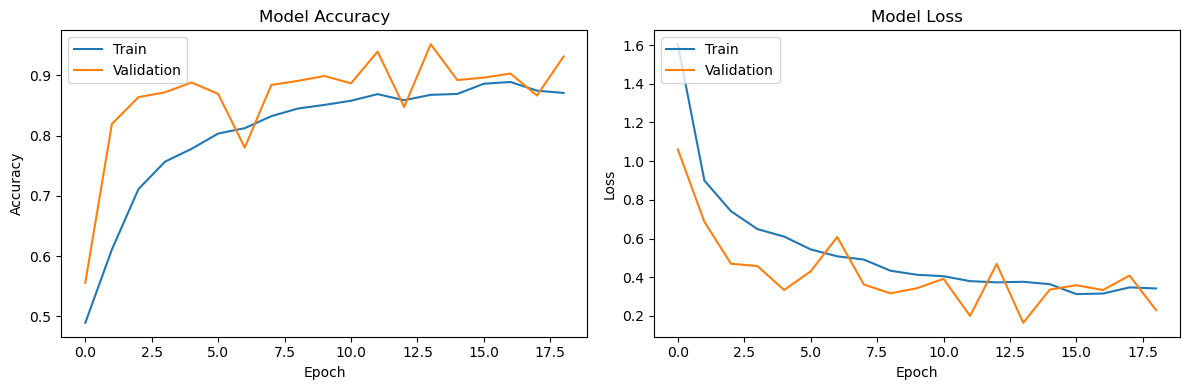

In [26]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

2025-05-14 22:40:24.743659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 4s 148ms/step


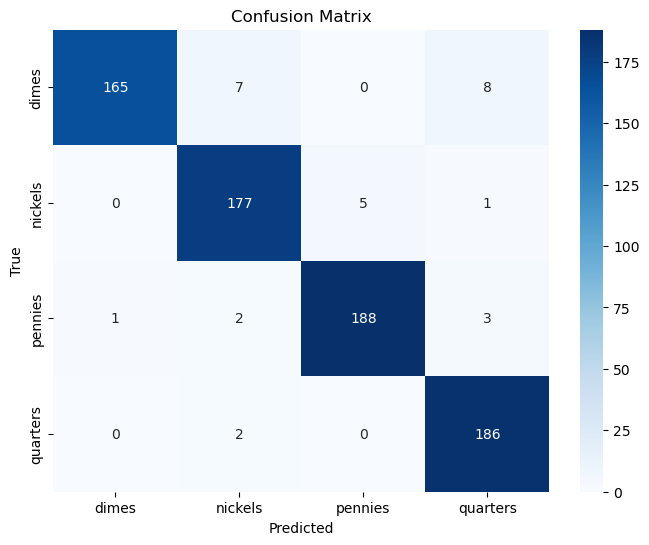

Classification Report:
              precision    recall  f1-score   support

       dimes       0.99      0.92      0.95       180
     nickels       0.94      0.97      0.95       183
     pennies       0.97      0.97      0.97       194
    quarters       0.94      0.99      0.96       188

    accuracy                           0.96       745
   macro avg       0.96      0.96      0.96       745
weighted avg       0.96      0.96      0.96       745



In [27]:
# Ensure y_true and y_pred are defined
class_labels = list(test_generator.class_indices.keys())

# Predict on the test set
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
cr = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:")
print(cr)


In [28]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

 1/24 [>.............................] - ETA: 4s - loss: 0.3225 - accuracy: 0.9062

2025-05-14 22:40:33.911654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 4s 147ms/step - loss: 0.1304 - accuracy: 0.9611
Test Loss: 0.1304376721382141
Test Accuracy: 0.9610738158226013


2025-05-15 00:20:40.154004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 3s 140ms/step


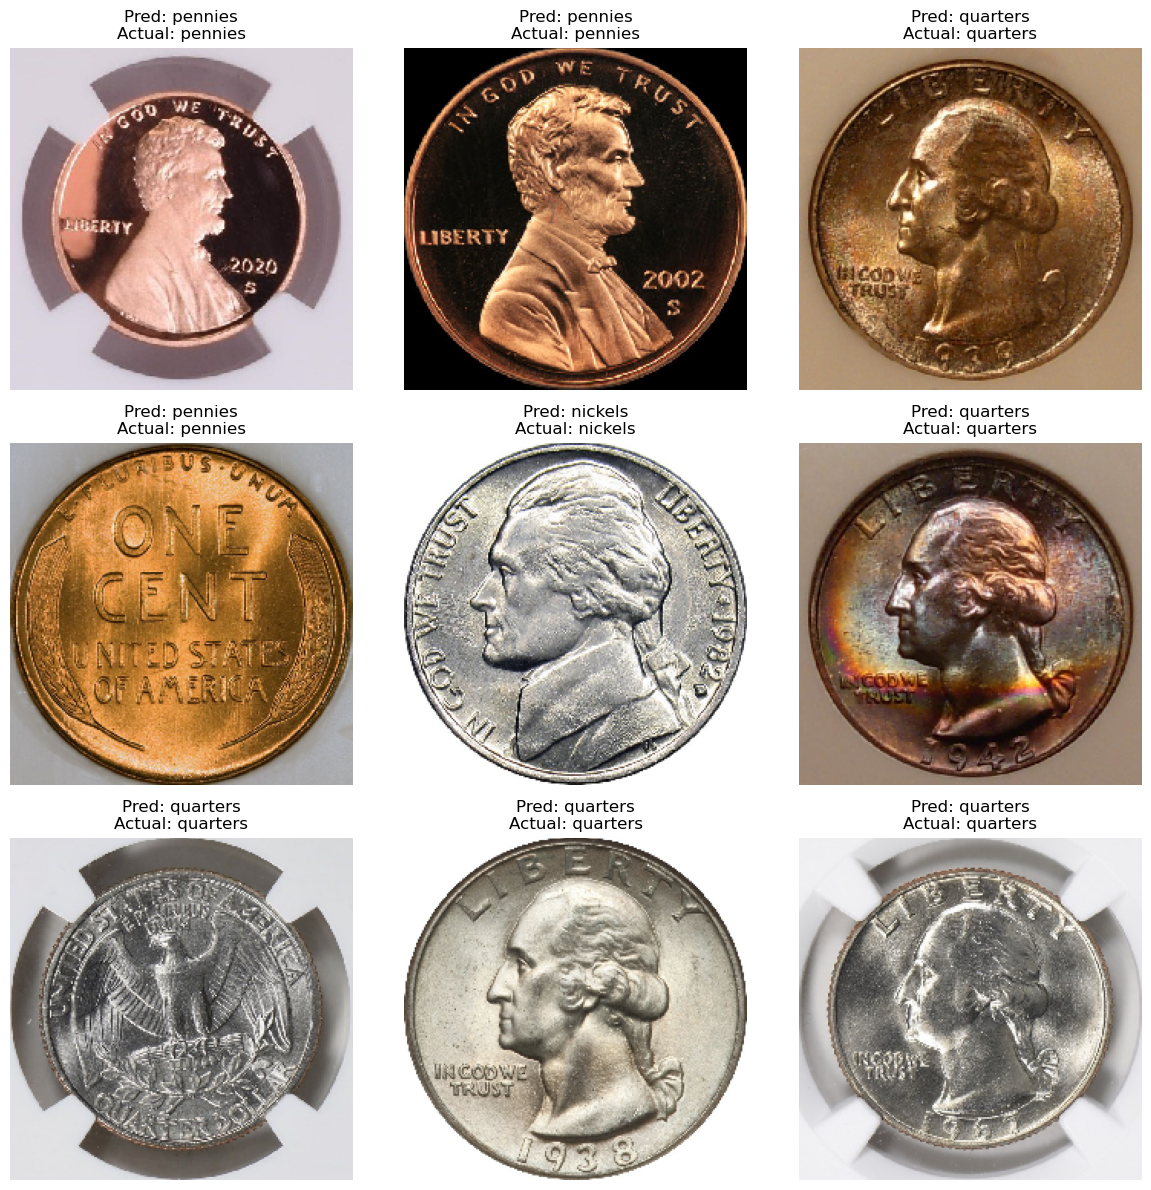

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('best_coin_model.h5')

# Predict on the test dataset
test_generator.reset()
y_pred_probs_best = best_model.predict(test_generator, verbose=1)
y_pred_best = np.argmax(y_pred_probs_best, axis=1)

# Display images 
plt.figure(figsize=(12, 12))
for i in range(9): 
    plt.subplot(3, 3, i + 1)
    img_idx = random.randint(0, len(test_generator.filenames) - 1)
    img_path = os.path.join(test_generator.directory, test_generator.filenames[img_idx])
    img = load_img(img_path, target_size=img_size)
    plt.imshow(img)
    plt.title(f"Pred: {class_labels[y_pred_best[img_idx]]}\nActual: {class_labels[y_true[img_idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()